<h1 style="text-align:center;">Quantitative Trading</h1>

<br>

<br>

# 01. Initial Deployment

---

### 01.1. Import the Libraries

In [1]:
# Import the libraries
import requests, time, datetime, pytz, talib, warnings
import yfinance as yf
from itertools import compress
import numpy as np
import pandas as pd

In [2]:
# Import the deep learning libraries
from tensorflow import keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# Import machine learning libraries
import sklearn
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor, LassoLars, PassiveAggressiveRegressor, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
# Import the visualization libraries
import seaborn as sns
import mplfinance as fplt
import matplotlib.pyplot as plt
%matplotlib inline

### 01.2. Customize the Pandas

In [5]:
# Show max rows
pd.set_option('display.max_rows', 200)

In [6]:
# Show max columns
pd.set_option('display.max_columns', None)

In [7]:
# Show 4 decimal point in dataframe
pd.options.display.float_format = "{:,.3f}".format

### 01.3. Customize the Matplotlib

In [8]:
# Set the matplotlib style
plt.style.use("seaborn-darkgrid")

### 01.4. Turn-Off the Warnings

In [9]:
# Turn off all warnings
warnings.filterwarnings('ignore')

<br>

# 02. Load the Dataset 

---

### 02.1. TD Ameritrade API

In [10]:
# Function for fetching the minute level dataset
def fetch_minute_dataset(ticker_name = "TSLA"):
    
    # Client ID
    client_id = "E5AXP16J02E3JTODQW9LW7L1AH726L9X"

    # Get the current time
    current_time_epoch = str(int(time.time()) * 1000)

    # Endpoint
    endpoint = r"https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format(ticker_name)

    # Define the payload                
    payload = {"apikey": client_id,
               #"periodType": "day",
               #"period": "*1",
               "frequencyType": "minute",
               "frequency": "1",
               "endDate": current_time_epoch,        # Use "www.epochconverter.com" for getting the time
               "startDate": "1620826200000",
               "needExtendedHoursData": "false"}      # Only regular market hour

    # Make a request
    content = requests.get(url = endpoint, params = payload)

    # Convert data into a json dictionary
    data = content.json()

    # Get the dataset in dataframe form
    data = pd.DataFrame(data["candles"])
    
    return data

In [11]:
df = fetch_minute_dataset(ticker_name = "SPY")
print("Dataset Shape: ", df.shape)
df

Dataset Shape:  (5301, 6)


,open,high,low,close,volume,datetime
0,411.230,411.710,410.940,411.660,646169,1620826200000
1,411.670,412.100,411.520,411.580,555916,1620826260000
2,411.580,411.880,411.280,411.880,288527,1620826320000
3,411.870,412.050,411.640,411.760,293702,1620826380000
4,411.770,412.040,411.690,411.980,246648,1620826440000
...,...,...,...,...,...,...
5296,421.230,421.230,421.170,421.170,1733,1622159700000
5297,421.190,421.190,421.110,421.150,1195,1622159760000
5298,421.130,421.190,421.100,421.150,6399,1622159820000
5299,421.160,421.180,421.150,421.150,1841,1622159880000


In [12]:
def add_different_date_columns(df):
    """
    Function for adding date columns (i.e. "datetime", "year", "month", "day", "hour", "minute", "day name").
    """
    
    # Create a "date" only column
    def converter(x):
        x = datetime.datetime.fromtimestamp(x/1000, pytz.timezone("US/Eastern"))
        return "{}/{}/{}".format(x.year, x.month, x.day)

    df["date"] = df["datetime"].map(lambda x: converter(x))
    
    # Create the year, month, day, hour, and minute columns
    df["year"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).year)
    df["month"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).month)
    df["day"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).day)
    df["hour"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).hour)
    df["minute"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).minute)
    df["day name"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%A"))
    
    return df

In [13]:
df = add_different_date_columns(df)
print("Dataset Shape: ", df.shape)
print("Unique Hours: ", df["hour"].unique())
df

Dataset Shape:  (5301, 13)
Unique Hours:  [17 18 19 20 21 22 23  0  1  2  3]


,open,high,low,close,volume,datetime,date,year,month,day,hour,minute,day name
0,411.230,411.710,410.940,411.660,646169,1620826200000,2021/5/12,2021,5,12,17,30,Wednesday
1,411.670,412.100,411.520,411.580,555916,1620826260000,2021/5/12,2021,5,12,17,31,Wednesday
2,411.580,411.880,411.280,411.880,288527,1620826320000,2021/5/12,2021,5,12,17,32,Wednesday
3,411.870,412.050,411.640,411.760,293702,1620826380000,2021/5/12,2021,5,12,17,33,Wednesday
4,411.770,412.040,411.690,411.980,246648,1620826440000,2021/5/12,2021,5,12,17,34,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5296,421.230,421.230,421.170,421.170,1733,1622159700000,2021/5/27,2021,5,28,3,55,Friday
5297,421.190,421.190,421.110,421.150,1195,1622159760000,2021/5/27,2021,5,28,3,56,Friday
5298,421.130,421.190,421.100,421.150,6399,1622159820000,2021/5/27,2021,5,28,3,57,Friday
5299,421.160,421.180,421.150,421.150,1841,1622159880000,2021/5/27,2021,5,28,3,58,Friday


In [14]:
# Get hours from 17 to 23 only
df = df[(df["hour"]>=17) & (df["hour"]<=23)]
print("Unique Hours: ", df["hour"].unique())
df

Unique Hours:  [17 18 19 20 21 22 23]


,open,high,low,close,volume,datetime,date,year,month,day,hour,minute,day name
0,411.230,411.710,410.940,411.660,646169,1620826200000,2021/5/12,2021,5,12,17,30,Wednesday
1,411.670,412.100,411.520,411.580,555916,1620826260000,2021/5/12,2021,5,12,17,31,Wednesday
2,411.580,411.880,411.280,411.880,288527,1620826320000,2021/5/12,2021,5,12,17,32,Wednesday
3,411.870,412.050,411.640,411.760,293702,1620826380000,2021/5/12,2021,5,12,17,33,Wednesday
4,411.770,412.040,411.690,411.980,246648,1620826440000,2021/5/12,2021,5,12,17,34,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,419.700,419.720,419.580,419.640,452521,1622145300000,2021/5/27,2021,5,27,23,55,Thursday
5066,419.645,419.810,419.600,419.785,434767,1622145360000,2021/5/27,2021,5,27,23,56,Thursday
5067,419.788,419.850,419.760,419.850,598496,1622145420000,2021/5/27,2021,5,27,23,57,Thursday
5068,419.860,419.880,419.720,419.870,660165,1622145480000,2021/5/27,2021,5,27,23,58,Thursday


In [15]:
# Negate hours with 8 (time difference)
df["hour"] = df["hour"].map(lambda x: int(x-8))
print("Unique Hours: ", df["hour"].unique())
df

Unique Hours:  [ 9 10 11 12 13 14 15]


,open,high,low,close,volume,datetime,date,year,month,day,hour,minute,day name
0,411.230,411.710,410.940,411.660,646169,1620826200000,2021/5/12,2021,5,12,9,30,Wednesday
1,411.670,412.100,411.520,411.580,555916,1620826260000,2021/5/12,2021,5,12,9,31,Wednesday
2,411.580,411.880,411.280,411.880,288527,1620826320000,2021/5/12,2021,5,12,9,32,Wednesday
3,411.870,412.050,411.640,411.760,293702,1620826380000,2021/5/12,2021,5,12,9,33,Wednesday
4,411.770,412.040,411.690,411.980,246648,1620826440000,2021/5/12,2021,5,12,9,34,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,419.700,419.720,419.580,419.640,452521,1622145300000,2021/5/27,2021,5,27,15,55,Thursday
5066,419.645,419.810,419.600,419.785,434767,1622145360000,2021/5/27,2021,5,27,15,56,Thursday
5067,419.788,419.850,419.760,419.850,598496,1622145420000,2021/5/27,2021,5,27,15,57,Thursday
5068,419.860,419.880,419.720,419.870,660165,1622145480000,2021/5/27,2021,5,27,15,58,Thursday


<br>

### 02.2. Yahoo Finance API

In [26]:
def load_dataset_yf(ticker_name, period='max', interval='1d',):
    
    # Set the ticker
    ticker = yf.Ticker(ticker_name)
    
    # Load the dataset
    df = ticker.history(period, interval).reset_index()
    
    # Rename the columns
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits']

    # Drop some columns
    df = df.drop(["dividends", "stock splits"], axis=1)
    
    return df

In [27]:
df = load_dataset_yf(ticker_name="SPY", period='max', interval='1d',)
df

,date,open,high,low,close,volume
0,1993-01-29,25.903,25.903,25.774,25.884,1003200
1,1993-02-01,25.903,26.068,25.903,26.068,480500
2,1993-02-02,26.050,26.142,25.995,26.123,201300
3,1993-02-03,26.160,26.418,26.142,26.400,529400
4,1993-02-04,26.492,26.565,26.197,26.510,531500
...,...,...,...,...,...,...
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700
7131,2021-05-25,420.330,420.710,417.620,418.240,57451400
7132,2021-05-26,418.870,419.610,417.760,419.070,43088600
7133,2021-05-27,420.170,420.720,418.990,419.290,56707700


In [28]:
# Set data as index
df = df.set_index("date")
df

,open,high,low,close,volume
date,,,,,
1993-01-29,25.903,25.903,25.774,25.884,1003200
1993-02-01,25.903,26.068,25.903,26.068,480500
1993-02-02,26.050,26.142,25.995,26.123,201300
1993-02-03,26.160,26.418,26.142,26.400,529400
1993-02-04,26.492,26.565,26.197,26.510,531500
...,...,...,...,...,...
2021-05-24,417.340,420.320,417.080,419.170,51376700
2021-05-25,420.330,420.710,417.620,418.240,57451400
2021-05-26,418.870,419.610,417.760,419.070,43088600


<br>

# 03. Feature Engineering

---

<br>

### 03.1. Add Indicators

In [30]:
# Add relative volume (i.e. percentage of change in volume)
df["price change"] = df["close"].pct_change()
df

,open,high,low,close,volume,price change
date,,,,,,
1993-01-29,25.903,25.903,25.774,25.884,1003200,NaN
1993-02-01,25.903,26.068,25.903,26.068,480500,0.007
1993-02-02,26.050,26.142,25.995,26.123,201300,0.002
1993-02-03,26.160,26.418,26.142,26.400,529400,0.011
1993-02-04,26.492,26.565,26.197,26.510,531500,0.004
...,...,...,...,...,...,...
2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010
2021-05-25,420.330,420.710,417.620,418.240,57451400,-0.002
2021-05-26,418.870,419.610,417.760,419.070,43088600,0.002


In [31]:
# Add relative volume (i.e. percentage of change in volume)
df["relative volume"] = df["volume"].pct_change()
df

,open,high,low,close,volume,price change,relative volume
date,,,,,,,
1993-01-29,25.903,25.903,25.774,25.884,1003200,NaN,NaN
1993-02-01,25.903,26.068,25.903,26.068,480500,0.007,-0.521
1993-02-02,26.050,26.142,25.995,26.123,201300,0.002,-0.581
1993-02-03,26.160,26.418,26.142,26.400,529400,0.011,1.630
1993-02-04,26.492,26.565,26.197,26.510,531500,0.004,0.004
...,...,...,...,...,...,...,...
2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,-0.329
2021-05-25,420.330,420.710,417.620,418.240,57451400,-0.002,0.118
2021-05-26,418.870,419.610,417.760,419.070,43088600,0.002,-0.250


In [32]:
# Add RSI
time_periods = [14]
for i in time_periods:
    df.loc[:, f"RSI_{i}"] = talib.RSI(df["close"], timeperiod = i)

In [33]:
# Add EMA
time_periods = [9, 20, 50, 200]
for i in time_periods:
    df.loc[:, f"EMA_{i}"] = talib.EMA(df["close"], timeperiod = i)

In [34]:
# Add MACD
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(df["close"], fastperiod=12, slowperiod=26, signalperiod=9)

In [35]:
# TODO: Add ATR

In [36]:
# TODO: Add momenum indicato

In [37]:
# TODO: Add Fibonacci 

In [38]:
# TODO: Add more indicators

In [39]:
# Replace infinity with NaN
df = df.replace([np.inf, -np.inf], np.nan)

In [40]:
# Remove rows with NaN values
df.dropna(inplace=True)

In [41]:
df

,open,high,low,close,volume,price change,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist
date,,,,,,,,,,,,,,,
1993-11-11,27.891,27.966,27.797,27.816,88900,-0.003,0.912,50.310,27.805,27.826,27.687,26.869,0.008,0.043,-0.034
1993-11-12,27.872,28.041,27.853,27.947,108200,0.005,0.217,54.494,27.834,27.837,27.697,26.880,0.018,0.038,-0.020
1993-11-15,28.003,28.003,27.853,27.928,243300,-0.001,1.249,53.797,27.853,27.846,27.706,26.890,0.024,0.035,-0.011
1993-11-16,27.985,28.078,27.872,28.060,492600,0.005,1.025,57.860,27.894,27.866,27.720,26.902,0.039,0.036,0.003
1993-11-17,28.078,28.078,27.835,27.910,39600,-0.005,-0.920,52.209,27.897,27.870,27.728,26.912,0.038,0.036,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,-0.329,57.543,415.083,414.365,407.968,373.710,1.518,1.966,-0.448
2021-05-25,420.330,420.710,417.620,418.240,57451400,-0.002,0.118,56.209,415.714,414.734,408.371,374.153,1.667,1.906,-0.239
2021-05-26,418.870,419.610,417.760,419.070,43088600,0.002,-0.250,57.163,416.385,415.147,408.791,374.600,1.831,1.891,-0.060


<br>

### 03.2. Add Trendlines 

In [198]:
temp_df = df.iloc[:50]

In [199]:
# TODO: Draw trend lines from SIGNIGICANT HIGH prices only
# TODO: Draw trend lines from SIGNIGICANT LOW prices only

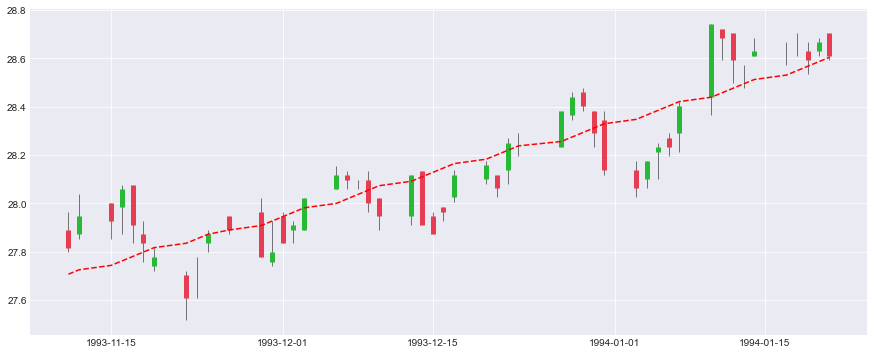

In [200]:
plt.figure(figsize=(15, 6))

# Vertical lines from low to high
plt.vlines(temp_df.index, temp_df["low"], temp_df["high"], alpha=0.5, linewidth=1, color="black")

# Green candle
green_df = temp_df[temp_df["open"]<temp_df["close"]]
plt.vlines(green_df.index, green_df["open"], green_df["close"], alpha=1, linewidth=5, color="#27ba36")

# Red candle
red_df = temp_df[temp_df["open"]>temp_df["close"]]
plt.vlines(red_df.index, red_df["open"], red_df["close"], alpha=1, linewidth=5, color="#e83c53")

# Draw trendline
x = temp_df["close"].reset_index().iloc[:, 1:].index.to_list()
y = list(temp_df["close"].reset_index().iloc[:, 1:].values.reshape(-1))
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(temp_df.index, p(x), "r--")

plt.show()

<br>

### 03.3. Add Support & Resistance Levels

In [315]:
temp_df = df.iloc[-350:-250]

In [316]:
s =  np.mean(temp_df['high'] - temp_df['low'])

In [317]:
def isSupport(df,i):
    support = df['low'][i] < df['low'][i-1]  and df['low'][i] < df['low'][i+1] \
    and df['low'][i+1] < df['low'][i+2] and df['low'][i-1] < df['low'][i-2]

    return support

def isResistance(df,i):
    resistance = df['high'][i] > df['high'][i-1]  and df['high'][i] > df['high'][i+1] \
    and df['high'][i+1] > df['high'][i+2] and df['high'][i-1] > df['high'][i-2] 

    return resistance

def isFarFromLevel(l):
    return np.sum([abs(l-x) < s  for x in levels]) == 0

In [318]:
levels = []
for i in range(2, temp_df.shape[0]-2):
    if isSupport(temp_df,i):
        l = temp_df['low'][i]

        if isFarFromLevel(l):
            levels.append((i,l))

    elif isResistance(temp_df,i):
        l = temp_df['high'][i]

        if isFarFromLevel(l):
            levels.append((i,l))

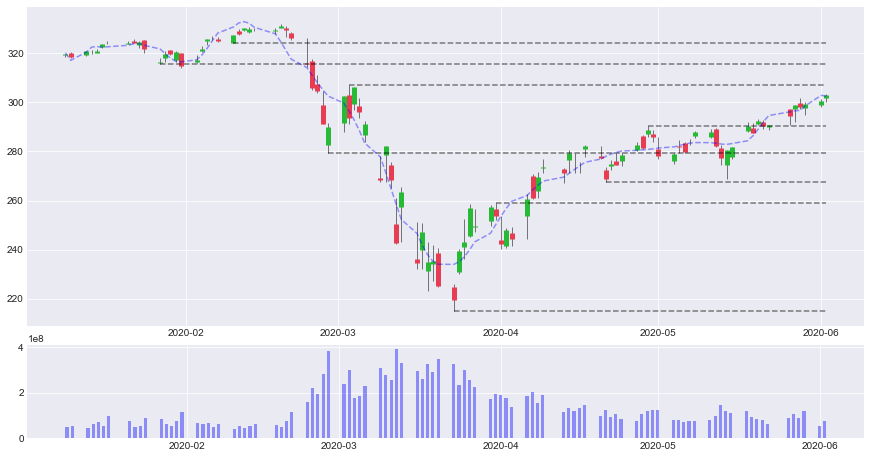

In [330]:
### TOP PLT

top_plt = plt.subplot2grid(shape=(5,4), loc=(0, 0), rowspan=3, colspan=4)

# Vertical lines from low to high
top_plt.vlines(temp_df.index, temp_df["low"], temp_df["high"], alpha=0.5, linewidth=1, color="black")

# Green candle
green_df = temp_df[temp_df["open"]<temp_df["close"]]
top_plt.vlines(green_df.index, green_df["open"], green_df["close"], alpha=1, linewidth=5, color="#27ba36")

# Red candle
red_df = temp_df[temp_df["open"]>temp_df["close"]]
top_plt.vlines(red_df.index, red_df["open"], red_df["close"], alpha=1, linewidth=5, color="#e83c53")

# Draw horizontal support and resistance lines
for level in levels:
    top_plt.hlines(level[1], xmin=temp_df.index.values[level[0]], xmax=max(temp_df.index.values), 
                   linestyles="dashed", colors='black', alpha=0.5)

# Draw trendline    
x = temp_df["close"].reset_index().iloc[:, 1:].index.to_list()
y = list(temp_df["close"].reset_index().iloc[:, 1:].values.reshape(-1))
z = np.polyfit(x, y, 20)
p = np.poly1d(z)
top_plt.plot(temp_df.index, p(x), "--", color="blue", alpha=0.4)        
    
    
### BOTTOM PLT

bottom_plt = plt.subplot2grid(shape=(5,4), loc=(3, 0), rowspan=1, colspan=4)
bottom_plt.bar(temp_df.index.values, temp_df.volume, color="blue", alpha=0.4, width=0.6)


plt.gcf().set_size_inches(15,10)

<br>

### 03.4. Add Correlated Asset Classes

In [335]:
# Add future S&P 500
spy_futures = load_dataset_yf(ticker_name="ES=F")
df = df.merge(spy_futures[["date", "close"]].rename({"close":"s&p futures price"}, axis=1), on="date")

In [336]:
# Add gold price
gold = load_dataset_yf(ticker_name="GLD")
df = df.merge(gold[["date", "close"]].rename({"close":"gold price"}, axis=1), on="date")

In [337]:
# Add gold future price
gold_futures = load_dataset_yf(ticker_name="GC=F")
df = df.merge(gold_futures[["date", "close"]].rename({"close":"gold futures price"}, axis=1), on="date")

In [338]:
# Add tresury bond 20 years price
bond = load_dataset_yf(ticker_name="TLT")
df = df.merge(bond[["date", "close"]].rename({"close":"20 years treasury bond"}, axis=1), on="date")

In [339]:
# TODO: Add more assets

In [340]:
df.head()

,date,open,high,low,close,volume,price change,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist,s&p futures price_x,gold price_x,gold futures price_x,20 years treasury bond_x,s&p futures price_y,gold price_y,gold futures price_y,20 years treasury bond_y
0,2004-11-18,85.450,85.645,85.234,85.602,31854300,0.001,-0.415,72.189,84.787,83.563,82.000,79.712,1.303,1.077,0.226,"1,185.000",44.380,442.600,52.144,"1,185.000",44.380,442.600,52.144
1,2004-11-19,85.573,85.587,84.448,84.650,54276500,-0.011,0.704,61.991,84.759,83.666,82.104,79.761,1.226,1.107,0.119,"1,172.250",44.780,446.800,51.728,"1,172.250",44.780,446.800,51.728
2,2004-11-22,84.470,85.155,84.369,85.054,37560200,0.005,-0.308,64.296,84.818,83.798,82.220,79.814,1.184,1.122,0.062,"1,178.000",44.950,448.800,51.997,"1,178.000",44.950,448.800,51.997
3,2004-11-23,85.018,85.256,84.614,85.184,41968800,0.002,0.117,65.029,84.891,83.930,82.336,79.867,1.148,1.128,0.021,"1,179.250",44.750,447.800,52.062,"1,179.250",44.750,447.800,52.062
4,2004-11-24,85.263,85.494,85.104,85.386,29724800,0.002,-0.292,66.194,84.990,84.069,82.456,79.922,1.123,1.127,-0.004,"1,182.000",45.050,449.300,52.062,"1,182.000",45.050,449.300,52.062


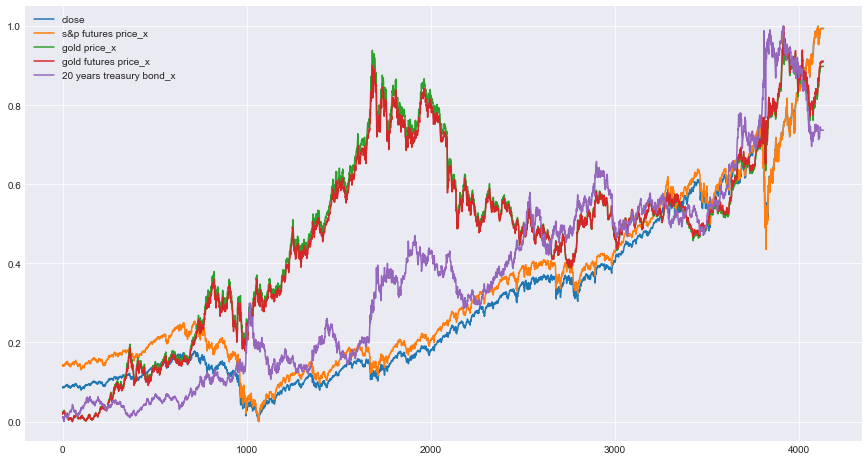

<AxesSubplot:>

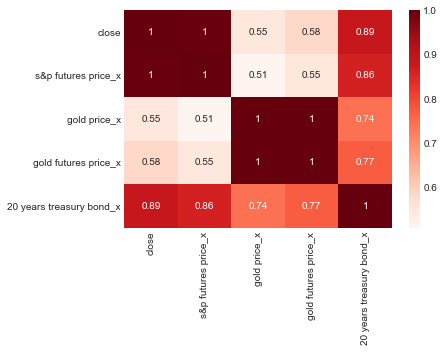

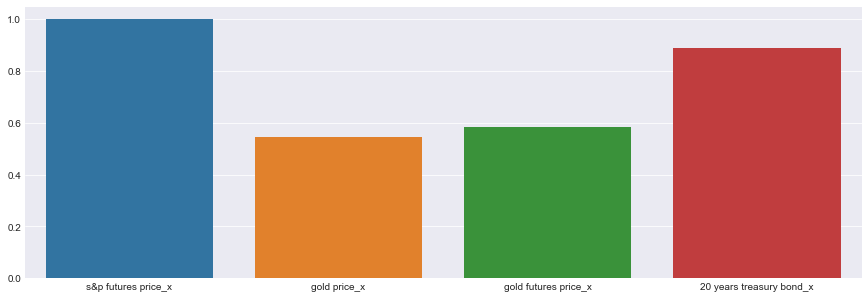

In [373]:
### Visualize the normalized prices

# Get the df
temp_df = df[["close", "s&p futures price_x", "gold price_x", "gold futures price_x", "20 years treasury bond_x"]]

# Get the scaler
scaler = sklearn.preprocessing.MinMaxScaler()
prices = scaler.fit_transform(temp_df.values)
temp_df = pd.DataFrame(prices, columns=temp_df.columns)

# Plot the prices
temp_df.plot(figsize=(15, 8))

# Plot
plt.show()

# Plot the correlation heatmap
sns.heatmap(temp_df.corr(), annot=True, cmap="Reds")

# Plot the correlated percentage to close prices
plt.figure(figsize=(15, 5))
sns.barplot(temp_df.corr()["close"][1:].index, temp_df.corr()["close"][1:].values, )

<br>

### 03.5. Add Candlestick Patterns

In [374]:
def add_candlestick_patterns(df):
    
    # Get the candle names
    candle_names = talib.get_function_groups()['Pattern Recognition']

    exclude_items = ('CDLCOUNTERATTACK',
                     'CDLLONGLINE',
                     'CDLSHORTLINE',
                     'CDLSTALLEDPATTERN',
                     'CDLKICKINGBYLENGTH')

    candle_names = [candle for candle in candle_names if candle not in exclude_items]
    
    # Create columns for each pattern
    for candle in candle_names:
        df[candle] = getattr(talib, candle)(df['open'], df['high'], df['low'], df['close'])
        
    # Create a candle ranking
    candle_rankings={"CDL3LINESTRIKE_Bull": 1, "CDL3LINESTRIKE_Bear": 2, "CDL3BLACKCROWS_Bull": 3, "CDL3BLACKCROWS_Bear": 3,
                    "CDLEVENINGSTAR_Bull": 4, "CDLEVENINGSTAR_Bear": 4, "CDLTASUKIGAP_Bull": 5, "CDLTASUKIGAP_Bear": 5,
                    "CDLINVERTEDHAMMER_Bull": 6, "CDLINVERTEDHAMMER_Bear": 6, "CDLMATCHINGLOW_Bull": 7, "CDLMATCHINGLOW_Bear": 7,
                    "CDLABANDONEDBABY_Bull": 8, "CDLABANDONEDBABY_Bear": 8, "CDLBREAKAWAY_Bull": 10, "CDLBREAKAWAY_Bear": 10,
                    "CDLMORNINGSTAR_Bull": 12, "CDLMORNINGSTAR_Bear": 12, "CDLPIERCING_Bull": 13, "CDLPIERCING_Bear": 13,
                    "CDLSTICKSANDWICH_Bull": 14, "CDLSTICKSANDWICH_Bear": 14, "CDLTHRUSTING_Bull": 15, "CDLTHRUSTING_Bear": 15,
                    "CDLINNECK_Bull": 17, "CDLINNECK_Bear": 17, "CDL3INSIDE_Bull": 20, "CDL3INSIDE_Bear": 56, "CDLHOMINGPIGEON_Bull": 21,
                    "CDLHOMINGPIGEON_Bear": 21, "CDLDARKCLOUDCOVER_Bull": 22, "CDLDARKCLOUDCOVER_Bear": 22, "CDLIDENTICAL3CROWS_Bull": 24,
                    "CDLIDENTICAL3CROWS_Bear": 24, "CDLMORNINGDOJISTAR_Bull": 25, "CDLMORNINGDOJISTAR_Bear": 25, "CDLXSIDEGAP3METHODS_Bull": 27,
                    "CDLXSIDEGAP3METHODS_Bear": 26, "CDLTRISTAR_Bull": 28, "CDLTRISTAR_Bear": 76, "CDLGAPSIDESIDEWHITE_Bull": 46,
                    "CDLGAPSIDESIDEWHITE_Bear": 29, "CDLEVENINGDOJISTAR_Bull": 30, "CDLEVENINGDOJISTAR_Bear": 30, "CDL3WHITESOLDIERS_Bull": 32,
                    "CDL3WHITESOLDIERS_Bear": 32, "CDLONNECK_Bull": 33, "CDLONNECK_Bear": 33, "CDL3OUTSIDE_Bull": 34, "CDL3OUTSIDE_Bear": 39,
                    "CDLRICKSHAWMAN_Bull": 35, "CDLRICKSHAWMAN_Bear": 35, "CDLSEPARATINGLINES_Bull": 36, "CDLSEPARATINGLINES_Bear": 40,
                    "CDLLONGLEGGEDDOJI_Bull": 37, "CDLLONGLEGGEDDOJI_Bear": 37, "CDLHARAMI_Bull": 38, "CDLHARAMI_Bear": 72,
                    "CDLLADDERBOTTOM_Bull": 41, "CDLLADDERBOTTOM_Bear": 41, "CDLCLOSINGMARUBOZU_Bull": 70, "CDLCLOSINGMARUBOZU_Bear": 43,
                    "CDLTAKURI_Bull": 47, "CDLTAKURI_Bear": 47, "CDLDOJISTAR_Bull": 49, "CDLDOJISTAR_Bear": 51, "CDLHARAMICROSS_Bull": 50,
                    "CDLHARAMICROSS_Bear": 80, "CDLADVANCEBLOCK_Bull": 54, "CDLADVANCEBLOCK_Bear": 54, "CDLSHOOTINGSTAR_Bull": 55,
                    "CDLSHOOTINGSTAR_Bear": 55, "CDLMARUBOZU_Bull": 71, "CDLMARUBOZU_Bear": 57, "CDLUNIQUE3RIVER_Bull": 60,
                    "CDLUNIQUE3RIVER_Bear": 60, "CDL2CROWS_Bull": 61, "CDL2CROWS_Bear": 61, "CDLBELTHOLD_Bull": 62,
                    "CDLBELTHOLD_Bear": 63, "CDLHAMMER_Bull": 65, "CDLHAMMER_Bear": 65, "CDLHIGHWAVE_Bull": 67, "CDLHIGHWAVE_Bear": 67,
                    "CDLSPINNINGTOP_Bull": 69, "CDLSPINNINGTOP_Bear": 73, "CDLUPSIDEGAP2CROWS_Bull": 74, "CDLUPSIDEGAP2CROWS_Bear": 74,
                    "CDLGRAVESTONEDOJI_Bull": 77, "CDLGRAVESTONEDOJI_Bear": 77, "CDLHIKKAKEMOD_Bull": 82, "CDLHIKKAKEMOD_Bear": 81,
                    "CDLHIKKAKE_Bull": 85, "CDLHIKKAKE_Bear": 83, "CDLENGULFING_Bull": 84, "CDLENGULFING_Bear": 91,
                    "CDLMATHOLD_Bull": 86, "CDLMATHOLD_Bear": 86, "CDLHANGINGMAN_Bull": 87, "CDLHANGINGMAN_Bear": 87,
                    "CDLRISEFALL3METHODS_Bull": 94, "CDLRISEFALL3METHODS_Bear": 89, "CDLKICKING_Bull": 96, "CDLKICKING_Bear": 102,
                    "CDLDRAGONFLYDOJI_Bull": 98, "CDLDRAGONFLYDOJI_Bear": 98, "CDLCONCEALBABYSWALL_Bull": 101, "CDLCONCEALBABYSWALL_Bear": 101,
                    "CDL3STARSINSOUTH_Bull": 103, "CDL3STARSINSOUTH_Bear": 103, "CDLDOJI_Bull": 104, "CDLDOJI_Bear": 104}
    
    df['candlestick_pattern'] = np.nan
    df['candlestick_match_count'] = np.nan

    for index, row in df.iterrows():

        # no pattern found
        if len(row[candle_names]) - sum(row[candle_names] == 0) == 0:
            df.loc[index,'candlestick_pattern'] = "NO_PATTERN"
            df.loc[index, 'candlestick_match_count'] = 0

        # single pattern found
        elif len(row[candle_names]) - sum(row[candle_names] == 0) == 1:

            # bull pattern 100 or 200
            if any(row[candle_names].values > 0):
                pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bull'
                df.loc[index, 'candlestick_pattern'] = pattern
                df.loc[index, 'candlestick_match_count'] = 1

            # bear pattern -100 or -200
            else:
                pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bear'
                df.loc[index, 'candlestick_pattern'] = pattern
                df.loc[index, 'candlestick_match_count'] = 1

        # multiple patterns matched -- select best performance
        else:

            # filter out pattern names from bool list of values
            patterns = list(compress(row[candle_names].keys(), row[candle_names].values != 0))
            container = []
            for pattern in patterns:
                if row[pattern] > 0:
                    container.append(pattern + '_Bull')
                else:
                    container.append(pattern + '_Bear')
            rank_list = [candle_rankings[p] for p in container]
            if len(rank_list) == len(container):
                rank_index_best = rank_list.index(min(rank_list))
                df.loc[index, 'candlestick_pattern'] = container[rank_index_best]
                df.loc[index, 'candlestick_match_count'] = len(container)
                
    # clean up candle columns
    df.drop(candle_names, axis = 1, inplace = True)
    
    word2id_candlestick_patterns = {i_pattern: index for index, i_pattern in enumerate(df["candlestick_pattern"].unique())}

    df["candlestick_pattern"] = df["candlestick_pattern"].map(lambda x: word2id_candlestick_patterns[x])

    return df, word2id_candlestick_patterns

In [375]:
df, word2id_candlestick_patterns = add_candlestick_patterns(df)

In [385]:
id2word_candlestick_patterns = {word2id_candlestick_patterns[i]: i for i in word2id_candlestick_patterns}

In [437]:
temp_df = pd.DataFrame(df["candlestick_pattern"].map(lambda x: id2word_candlestick_patterns[x]))
temp_df = temp_df.merge(df[["open", "high", "low", "close", "volume"]], on="date")
temp_df

,candlestick_pattern,open,high,low,close,volume
date,,,,,,
2004-11-18,NO_PATTERN,85.450,85.645,85.234,85.602,31854300
2004-11-19,NO_PATTERN,85.573,85.587,84.448,84.650,54276500
2004-11-22,NO_PATTERN,84.470,85.155,84.369,85.054,37560200
2004-11-23,NO_PATTERN,85.018,85.256,84.614,85.184,41968800
2004-11-24,NO_PATTERN,85.263,85.494,85.104,85.386,29724800
...,...,...,...,...,...,...
2021-05-28,CDLMATCHINGLOW_Bull,420.970,421.250,419.790,420.040,58486000
2021-05-28,CDLMATCHINGLOW_Bull,420.970,421.250,419.790,420.040,58486000
2021-05-28,CDLMATCHINGLOW_Bull,420.970,421.250,419.790,420.040,58486000


In [438]:
temp_df = temp_df.iloc[:50]

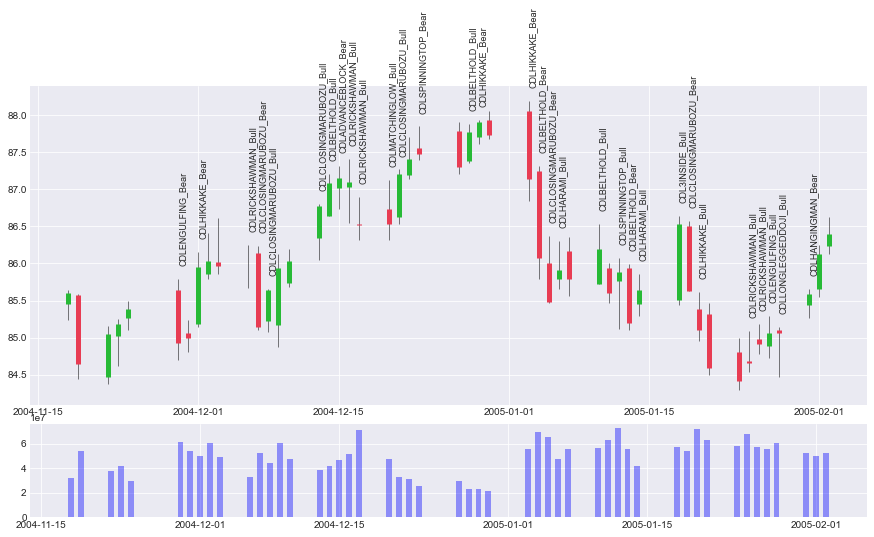

In [445]:
### TOP PLT

top_plt = plt.subplot2grid(shape=(5,4), loc=(0, 0), rowspan=3, colspan=4)

# Vertical lines from low to high
top_plt.vlines(temp_df.index, temp_df["low"], temp_df["high"], alpha=0.5, linewidth=1, color="black")

# Green candle
green_df = temp_df[temp_df["open"]<temp_df["close"]]
top_plt.vlines(green_df.index, green_df["open"], green_df["close"], alpha=1, linewidth=5, color="#27ba36")

# Red candle
red_df = temp_df[temp_df["open"]>temp_df["close"]]
top_plt.vlines(red_df.index, red_df["open"], red_df["close"], alpha=1, linewidth=5, color="#e83c53")

# Plot the texts
for i in range(len(temp_df)):
    if temp_df.candlestick_pattern[i]=="NO_PATTERN":
        continue
    plt.text(x=temp_df.index.values[i], 
             y=temp_df.high[i]+0.2, 
             s=temp_df.candlestick_pattern[i], 
             rotation=90, 
             fontdict={"size":9}) 
    
    
### BOTTOM PLT

bottom_plt = plt.subplot2grid(shape=(5,4), loc=(3, 0), rowspan=1, colspan=4)
bottom_plt.bar(temp_df.index.values, temp_df.volume, color="blue", alpha=0.4, width=0.6)


plt.gcf().set_size_inches(15,10)

TODO:
- Give bettern naming and structure
- See https://mrjbq7.github.io/ta-lib/func_groups/pattern_recognition.html

<br>

### 03.6. Add Fundamental Information

In [ ]:
# TODO: 

<br>

### 03.7. Add News Sentiment

<br>

### 03.8. Feature Importance & Feature Selection

<br>

# 04. Dataset Establishment


---

<br>

### 04.1. Prepare Input and Output

<br>

### 04.2. Split the Data into Training and Testing Set

<br>

### 04.3. Reshape Dataset for the Model

<br>

# 05. Model Construction


---

### 03.1. Define Output (i.e. Profit Rate)

In [16]:
# Add price change
df["price diff"] = df['close'].pct_change().shift(-1)
df

,date,open,high,low,close,volume,price diff
0,1993-01-29,25.903,25.903,25.774,25.884,1003200,0.007
1,1993-02-01,25.903,26.068,25.903,26.068,480500,0.002
2,1993-02-02,26.050,26.142,25.995,26.123,201300,0.011
3,1993-02-03,26.160,26.418,26.142,26.400,529400,0.004
4,1993-02-04,26.492,26.565,26.197,26.510,531500,-0.001
...,...,...,...,...,...,...,...
7128,2021-05-20,411.800,416.630,411.670,415.280,78022200,-0.001
7129,2021-05-21,416.870,418.200,414.450,414.940,76519100,0.010
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700,-0.002
7131,2021-05-25,420.330,420.710,417.620,418.240,57451400,0.002


In [17]:
df["next close"] = df["close"].shift(-1)
df

,date,open,high,low,close,volume,price diff,next close
0,1993-01-29,25.903,25.903,25.774,25.884,1003200,0.007,26.068
1,1993-02-01,25.903,26.068,25.903,26.068,480500,0.002,26.123
2,1993-02-02,26.050,26.142,25.995,26.123,201300,0.011,26.400
3,1993-02-03,26.160,26.418,26.142,26.400,529400,0.004,26.510
4,1993-02-04,26.492,26.565,26.197,26.510,531500,-0.001,26.492
...,...,...,...,...,...,...,...,...
7128,2021-05-20,411.800,416.630,411.670,415.280,78022200,-0.001,414.940
7129,2021-05-21,416.870,418.200,414.450,414.940,76519100,0.010,419.170
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700,-0.002,418.240
7131,2021-05-25,420.330,420.710,417.620,418.240,57451400,0.002,419.070


### Feature Importance & Feature Selection

In [82]:
# Get the x and y
#X=df.drop(["price diff", "date", "year", "month", "day", "hour", "minute", "datetime", "day name"], axis=1)
X=df.drop(["price diff", "next close", "date"], axis=1)
y_reg=df[["price diff"]].rename({"price diff": "output - regression"}, axis=1)
y_cl=pd.DataFrame(df["price diff"].map(lambda x: 1 if x>0 else -1)).rename({"price diff": "output - classification"}, axis=1)

In [83]:
# Scale the data
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [84]:
# Convert to dataframe + Change the column names
df_scaled = pd.DataFrame(X_scaled, columns=list(X.columns.values))

In [85]:
# Add the target output to the dataframe
df_scaled["output - regression"] = y_reg["output - regression"].reset_index().iloc[:, 1:]
df_scaled["output - classification"] = y_cl["output - classification"].reset_index().iloc[:, 1:]

In [86]:
df_scaled = df_scaled.dropna()

In [87]:
df_scaled

,open,high,low,close,volume,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist,s&p futures price,gold price,gold futures price,20 years treasury bond,candlestick_pattern,candlestick_match_count,output - regression,output - classification
0,-0.957,-0.961,-0.953,-0.955,-1.081,-1.282,1.464,-0.966,-0.981,-1.002,-1.029,0.355,0.264,0.344,-0.889,-1.952,-1.938,-1.396,-0.848,-0.882,-0.011,-1
1,-0.956,-0.962,-0.962,-0.967,-0.849,1.732,0.563,-0.966,-0.980,-1.001,-1.028,0.318,0.279,0.181,-0.906,-1.941,-1.927,-1.410,-0.848,-0.882,0.005,1
2,-0.969,-0.967,-0.963,-0.962,-1.022,-0.992,0.766,-0.965,-0.979,-0.999,-1.028,0.298,0.287,0.093,-0.898,-1.936,-1.922,-1.400,-0.848,-0.882,0.002,1
3,-0.962,-0.966,-0.960,-0.960,-0.976,0.153,0.831,-0.965,-0.977,-0.998,-1.027,0.281,0.290,0.030,-0.897,-1.942,-1.925,-1.398,-0.848,-0.882,0.002,1
4,-0.959,-0.963,-0.954,-0.958,-1.103,-0.949,0.934,-0.963,-0.975,-0.996,-1.026,0.269,0.289,-0.007,-0.893,-1.933,-1.921,-1.398,-0.848,-0.882,-0.001,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,2.926,2.951,2.933,2.972,-0.310,1.937,-0.674,3.022,3.047,3.028,2.835,0.309,1.017,-2.070,2.970,1.691,1.805,1.429,1.088,0.155,0.011,1
4111,2.985,3.018,3.010,3.026,-0.604,-0.882,-0.209,3.026,3.049,3.032,2.840,0.321,0.882,-1.625,3.026,1.713,1.807,1.467,-0.267,-0.364,-0.001,-1
4112,3.046,3.037,3.044,3.022,-0.619,-0.215,-0.248,3.029,3.051,3.035,2.846,0.311,0.772,-1.326,3.023,1.715,1.793,1.482,-0.848,-0.882,0.010,1
4113,3.051,3.062,3.076,3.073,-0.879,-1.048,0.170,3.041,3.057,3.041,2.852,0.457,0.715,-0.686,3.078,1.724,1.814,1.499,-0.848,-0.882,-0.002,-1


##### Filter Method

In [46]:
# Get the correlation matrix
correlation_matrix = df_scaled.corr()

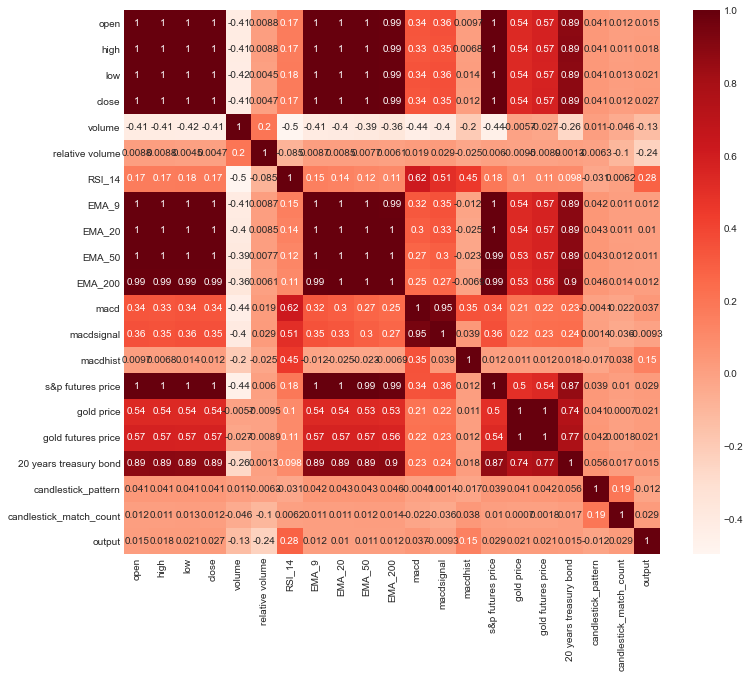

In [47]:
# Visualize the correlation map
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

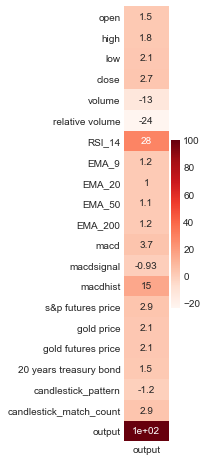

In [48]:
# Visualize the correlation map related to output only
plt.figure(figsize=(1,8))
sns.heatmap(df_scaled.corr()[["output"]]*100, annot=True, cmap=plt.cm.Reds)
plt.show()

In [186]:
# TODO: Drop columns that have near to zero correlation (i.e. less than 0.5)


In [187]:
# TODO: Drop columns that have high correlation


##### Wrapper Methods - Backward Elimination

In [89]:
X = df_scaled.drop(["next close", "output"], axis=1)
y = df_scaled["next close"]

In [90]:
# Initialize the model
model = Ridge()

# Fit the model
model.fit(X=X.to_numpy(), y=y.to_numpy())

# Get the p-values
model.coef_

array([ 5.00806525e-02,  1.67590455e-01,  2.33338061e-01,  3.20655825e-01,
       -2.23002433e-04, -5.27587317e-04,  2.38322212e-03,  7.14271444e-02,
        7.57083794e-02,  3.95722808e-02,  1.12456623e-02,  2.45493599e-03,
        1.16665092e-03,  4.36732237e-03,  2.57602743e-02, -3.19601115e-02,
        3.49787900e-02,  1.09352366e-03])

In [93]:
# Get the columns
cols = list(X.columns)

# Set the maximum p value
pmax = 1

# While length of column is bigger than zero
while(len(cols)>0):
    
    # Initialize a list for p values
    p = []
    
    #
    X_1 = X[cols]
    
    # Initialize the model
    model = Ridge()
    
    # Fit to the model
    model.fit(X=X_1, y=y)
    
    # Get the p-values inside a series
    p = pd.Series(model.coef_, index=cols)
    
    # Get the pmax
    pmax = max(p)
    
    # Get the features with pmax
    feature_with_p_max = p.idxmax()
    
    # If pmax is bigger than 0.05
    if (pmax>0.05):
        
        # Remove the feature from columns
        cols.remove(feature_with_p_max)
        
    # If pmax is less than 0.05
    else:
        
        # Break the loop
        break
        
# Set the selected features
selected_features = cols
print(selected_features)

['volume', 'RSI_14', 'macdhist']


In [94]:
# Backward Elimination - dropping columns which their pvalue is above 0.05
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

NameError: name 'sm' is not defined

##### Wrapper Methods - RFE (Recursive Feature Elimination)

In [95]:
# Rank the columns (1 being the most important one)
model = LinearRegression()
rfe = feature_selection.RFE(model, n_features_to_select=7)
X_rfe = rfe.fit_transform(X_scaled,y)  
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

NameError: name 'feature_selection' is not defined

In [ ]:
pd.DataFrame(rfe.ranking_, index=X.columns, columns=["Rank"])

In [96]:
# Get the optimal number of features
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

NameError: name 'RFE' is not defined

In [ ]:
# Feed the optial number of features as number of features to RFE and get the final set of features
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

##### Embedded Method

In [56]:
X = df_scaled.drop("next close", axis=1).to_numpy()
y = df_scaled["next close"].to_numpy()

In [63]:
n_sample = 1000
X_sample = X[:n_sample]
y_sample = y[:n_sample]

In [64]:
model_tree = GradientBoostingRegressor(n_estimators=100)
model_tree.fit(X_sample, y_sample)
model_tree.feature_importances_ 

array([2.85211588e-02, 3.36041542e-02, 9.15940862e-02, 6.20267104e-01,
       7.48716889e-04, 3.02954344e-04, 1.63878598e-04, 1.39864918e-01,
       1.36264128e-02, 9.59991793e-04, 2.80825231e-04, 5.00139823e-04,
       4.57652878e-04, 3.51275818e-04, 6.61210312e-02, 4.20700827e-04,
       9.07529625e-05, 1.46472343e-03, 6.59522458e-04])

In [65]:
model_ridge = Ridge()
model_ridge.fit(X_sample, y_sample)
model_ridge.coef_

array([ 0.08206152,  0.10354949,  0.10573465,  0.12021447, -0.00174636,
        0.00046484,  0.0029287 ,  0.09963497,  0.10035894,  0.09821065,
        0.07694535,  0.00503514,  0.00417873,  0.00357894,  0.16185937,
       -0.01033606,  0.01274268, -0.00484281,  0.03606733])

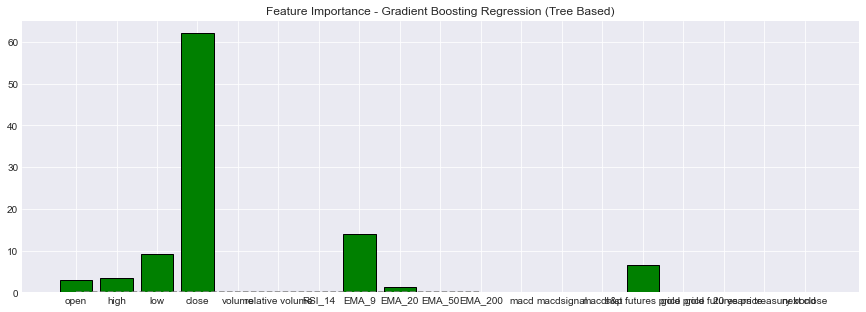

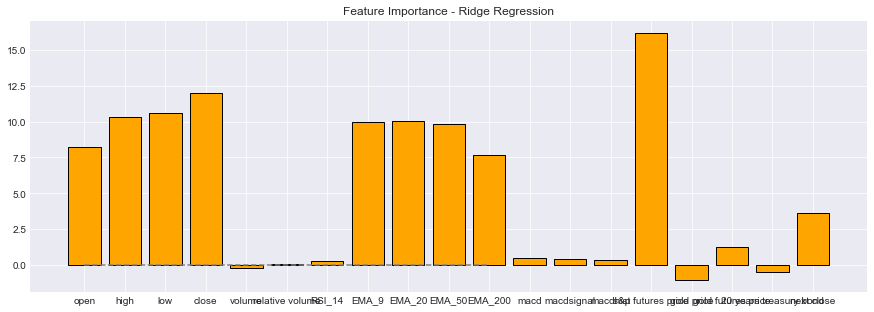

In [66]:
plt.figure(figsize=(15,5))
f1 = pd.DataFrame(model_tree.feature_importances_*100, index=list(df_scaled.drop("output", axis=1).columns.values))
plt.bar(x = list(f1.index),
        height = f1[0].values,
        color="green",
        edgecolor="black")
plt.hlines(0, 0, 10, linestyles="dashed", color="gray")
plt.title("Feature Importance - Gradient Boosting Regression (Tree Based)")
plt.show()

plt.figure(figsize=(15,5))
f2 = pd.DataFrame(model_ridge.coef_*100, index=list(df_scaled.drop("output", axis=1).columns.values))
plt.bar(x = list(f2.index),
        height = f2[0].values,
        color="orange",
        edgecolor="black")
plt.hlines(0, 0, 10, linestyles="dashed", color="gray")
plt.title("Feature Importance - Ridge Regression")
plt.show()

# Models

### Machine Learning

In [95]:
df_scaled

,open,high,low,close,volume,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist,s&p futures price,gold price,gold futures price,20 years treasury bond,candlestick_pattern,candlestick_match_count,output - regression,output - classification
0,-0.957,-0.961,-0.953,-0.955,-1.081,-1.282,1.464,-0.966,-0.981,-1.002,-1.029,0.355,0.264,0.344,-0.889,-1.952,-1.938,-1.396,-0.848,-0.882,-0.011,-1
1,-0.956,-0.962,-0.962,-0.967,-0.849,1.732,0.563,-0.966,-0.980,-1.001,-1.028,0.318,0.279,0.181,-0.906,-1.941,-1.927,-1.410,-0.848,-0.882,0.005,1
2,-0.969,-0.967,-0.963,-0.962,-1.022,-0.992,0.766,-0.965,-0.979,-0.999,-1.028,0.298,0.287,0.093,-0.898,-1.936,-1.922,-1.400,-0.848,-0.882,0.002,1
3,-0.962,-0.966,-0.960,-0.960,-0.976,0.153,0.831,-0.965,-0.977,-0.998,-1.027,0.281,0.290,0.030,-0.897,-1.942,-1.925,-1.398,-0.848,-0.882,0.002,1
4,-0.959,-0.963,-0.954,-0.958,-1.103,-0.949,0.934,-0.963,-0.975,-0.996,-1.026,0.269,0.289,-0.007,-0.893,-1.933,-1.921,-1.398,-0.848,-0.882,-0.001,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,2.926,2.951,2.933,2.972,-0.310,1.937,-0.674,3.022,3.047,3.028,2.835,0.309,1.017,-2.070,2.970,1.691,1.805,1.429,1.088,0.155,0.011,1
4111,2.985,3.018,3.010,3.026,-0.604,-0.882,-0.209,3.026,3.049,3.032,2.840,0.321,0.882,-1.625,3.026,1.713,1.807,1.467,-0.267,-0.364,-0.001,-1
4112,3.046,3.037,3.044,3.022,-0.619,-0.215,-0.248,3.029,3.051,3.035,2.846,0.311,0.772,-1.326,3.023,1.715,1.793,1.482,-0.848,-0.882,0.010,1
4113,3.051,3.062,3.076,3.073,-0.879,-1.048,0.170,3.041,3.057,3.041,2.852,0.457,0.715,-0.686,3.078,1.724,1.814,1.499,-0.848,-0.882,-0.002,-1


In [89]:
index_to_cut = int(df_scaled.shape[0]*0.90)

x_train = df_scaled.drop(["output - regression", "output - classification"], axis=1).to_numpy()[:index_to_cut]
y_train_regression = df_scaled["output - regression"].to_numpy()[:index_to_cut]
y_train_classification = df_scaled["output - classification"].to_numpy()[:index_to_cut]
print("Training set length: ", x_train.shape[0])

x_test = df_scaled.drop(["output - regression", "output - classification"], axis=1).to_numpy()[index_to_cut:]
y_test_regression = df_scaled["output - regression"].to_numpy()[index_to_cut:]
y_test_classification = df_scaled["output - classification"].to_numpy()[index_to_cut:]
print("Testing set length: ", x_test.shape[0])

Training set length:  3703
Testing set length:  412


In [90]:
print("Training From {} till {}.".format(str(df.loc[:index_to_cut, "date"].to_numpy()[0])[:10],
                                         str(df.loc[:index_to_cut, "date"].to_numpy()[-1])[:10]))

print("Testing From {} till {}.".format(str(df.loc[index_to_cut:, "date"].to_numpy()[0])[:10],
                                         str(df.loc[index_to_cut:, "date"].to_numpy()[-1])[:10]))

Training From 2004-11-18 till 2019-10-01.
Testing From 2019-10-01 till 2021-05-25.


In [91]:
# prepare a list of ml models
def get_models(models=dict()):
    
    # Linear models
    models['linear_regression'] = LinearRegression()
    models['lasso_regressor'] = Lasso()
    models['ridge_regressor'] = Ridge()
    models['elastic_net_regressor'] = ElasticNet()
    models['huber_regressor'] = HuberRegressor()
    models['lasso_lars_regressor'] = LassoLars()
    models['passive_aggressive_regressor'] = PassiveAggressiveRegressor( tol=1e-3)
    models['sgd_regressor'] = SGDRegressor(tol=1e-3)
    
    # Non-linear models
    models['knn_regressor'] = KNeighborsRegressor(n_neighbors=7)
    models['cart_decision_tree_regressor'] = DecisionTreeRegressor()
    models['extra_tree_regressor'] = ExtraTreeRegressor()
    models['support_vector_regressor'] = SVR()
    
    # Ensemble models
    n_trees = 100
    models['ada_boost_regressor'] = AdaBoostRegressor(n_estimators=n_trees)
    models['bagging_regressor'] = BaggingRegressor(n_estimators=n_trees)
    models['random_forest_regressor'] = RandomForestRegressor(n_estimators=n_trees)
    models['extra_tree_regressor_2'] = ExtraTreesRegressor(n_estimators=n_trees)
    models['gradient_boosting_regressor'] = GradientBoostingRegressor(n_estimators=n_trees)
    
    print('Defined %d models' % len(models))
    
    return models

In [92]:
models = get_models()
models

Defined 17 models


{'linear_regression': LinearRegression(),
 'lasso_regressor': Lasso(),
 'ridge_regressor': Ridge(),
 'elastic_net_regressor': ElasticNet(),
 'huber_regressor': HuberRegressor(),
 'lasso_lars_regressor': LassoLars(),
 'passive_aggressive_regressor': PassiveAggressiveRegressor(),
 'sgd_regressor': SGDRegressor(),
 'knn_regressor': KNeighborsRegressor(n_neighbors=7),
 'cart_decision_tree_regressor': DecisionTreeRegressor(),
 'extra_tree_regressor': ExtraTreeRegressor(),
 'support_vector_regressor': SVR(),
 'ada_boost_regressor': AdaBoostRegressor(n_estimators=100),
 'bagging_regressor': BaggingRegressor(n_estimators=100),
 'random_forest_regressor': RandomForestRegressor(),
 'extra_tree_regressor_2': ExtraTreesRegressor(),
 'gradient_boosting_regressor': GradientBoostingRegressor()}

In [45]:
# Loop over the keys of the dictionary
for i_key in models.keys():
    
    # Fit the model to the dataset
    models[i_key].fit(X=x_train, y=y_train_regression)
    
    # Make prediction
    preds = models[i_key].predict(x_test)
    
    # Calculate metrics
    mse = sklearn.metrics.mean_squared_error(np.array(y_test_regression), preds)
    accuracy = sklearn.metrics.accuracy_score(np.array(y_test_regression, "int"), np.array(np.round(preds), "int"))
    
    # Report
    print("====================================================")
    print("Model: ", i_key)
    print("Mean Square Error (MSE): {:.10f}".format(mse))
    print("Accuracy: %{:.2f}".format(accuracy*100))
    print("====================================================")

Model:  linear_regression
Mean Square Error (MSE): 0.0002812837
Accuracy: %100.00
Model:  lasso_regressor
Mean Square Error (MSE): 0.0002956181
Accuracy: %100.00
Model:  ridge_regressor
Mean Square Error (MSE): 0.0002932255
Accuracy: %100.00
Model:  elastic_net_regressor
Mean Square Error (MSE): 0.0002956181
Accuracy: %100.00
Model:  huber_regressor
Mean Square Error (MSE): 0.0002913585
Accuracy: %100.00
Model:  lasso_lars_regressor
Mean Square Error (MSE): 0.0002956181
Accuracy: %100.00
Model:  passive_aggressive_regressor
Mean Square Error (MSE): 0.0003611373
Accuracy: %100.00
Model:  sgd_regressor
Mean Square Error (MSE): 0.0003084218
Accuracy: %100.00
Model:  knn_regressor
Mean Square Error (MSE): 0.0003003425
Accuracy: %100.00
Model:  cart_decision_tree_regressor
Mean Square Error (MSE): 0.0006884853
Accuracy: %100.00
Model:  extra_tree_regressor
Mean Square Error (MSE): 0.0004476642
Accuracy: %100.00
Model:  support_vector_regressor
Mean Square Error (MSE): 0.0009991046
Accuracy:

In [93]:
# Loop over the keys of the dictionary
for i_key in models.keys():
    
    # Fit the model to the dataset
    models[i_key].fit(X=x_train, y=y_train_classification)
    
    # Make prediction
    preds = models[i_key].predict(x_test)
    
    # Calculate metrics
    mse = sklearn.metrics.mean_squared_error(np.array(y_test_classification), preds)
    accuracy = sklearn.metrics.accuracy_score(np.array(y_test_classification, "int"), np.array(np.round(preds), "int"))
    
    # Report
    print("====================================================")
    print("Model: ", i_key)
    print("Mean Square Error (MSE): {:.10f}".format(mse))
    print("Accuracy: %{:.2f}".format(accuracy*100))
    print("====================================================")

Model:  linear_regression
Mean Square Error (MSE): 1.0044453847
Accuracy: %1.70
Model:  lasso_regressor
Mean Square Error (MSE): 0.9747812942
Accuracy: %0.00
Model:  ridge_regressor
Mean Square Error (MSE): 0.9933130762
Accuracy: %1.46
Model:  elastic_net_regressor
Mean Square Error (MSE): 0.9747812942
Accuracy: %0.00
Model:  huber_regressor
Mean Square Error (MSE): 1.0028907158
Accuracy: %1.70
Model:  lasso_lars_regressor
Mean Square Error (MSE): 0.9747812942
Accuracy: %0.00
Model:  passive_aggressive_regressor
Mean Square Error (MSE): 18.9698659831
Accuracy: %1.46
Model:  sgd_regressor
Mean Square Error (MSE): 1.0268210342
Accuracy: %0.24
Model:  knn_regressor
Mean Square Error (MSE): 1.1301763424
Accuracy: %8.50
Model:  cart_decision_tree_regressor
Mean Square Error (MSE): 1.9417475728
Accuracy: %51.46
Model:  extra_tree_regressor
Mean Square Error (MSE): 2.1844660194
Accuracy: %45.39
Model:  support_vector_regressor
Mean Square Error (MSE): 1.0362994652
Accuracy: %6.07
Model:  ada_

In [53]:
# Fit the model to the dataset
models["lasso_regressor"].fit(X=x_train, y=y_train)

# Make prediction
preds = models["lasso_regressor"].predict(x_test)

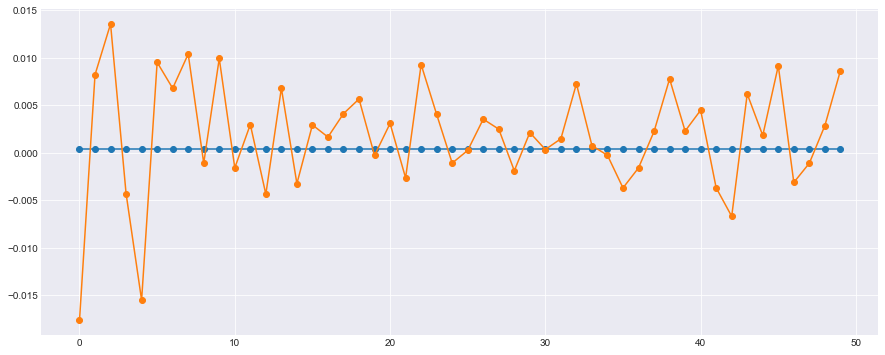

In [54]:
plt.figure(figsize=(15, 6))
plt.plot(preds[:50], "o-")
plt.plot(y_test[:50], "o-")

In [55]:
thumps_up_counter = 0
thumps_down_counter = 0

for i in range(1, len(x_test)):
    
    prediction_ = preds[i]*100
    true_output_ = y_test[i]*100
    
    true_trend = y_test[i]*100 - y_test[i-1]*100
    pred_trend = preds[i]*100 - preds[i-1]*100
    
    print("===================================================")
    print(f"PREDICTION #{i}")
    print("Prediction: {:.2f}%, True Output: {:.2f}%, Difference: {:.2f}".format(prediction_, true_output_, abs(prediction_-true_output_)))

    if ((true_trend>=0) & (pred_trend>=0)) | ((true_trend<0) & (pred_trend<0)):
        print("Correct trend 👍")
        thumps_up_counter+= 1
    else:
        print("Incorrectly trend 👎")
        thumps_down_counter+= 1
    print("===================================================")
    
print(f"Correctly predicted the trend for {thumps_up_counter} times (i.e {round(thumps_up_counter/(thumps_up_counter+thumps_down_counter), 2)*100}%) 👍")
print(f"Incorrect predicted the trend for {thumps_down_counter} times (i.e {round(thumps_down_counter/(thumps_up_counter+thumps_down_counter), 2)*100}%) 👎")

PREDICTION #310
Prediction: 0.04%, True Output: 0.14%, Difference: 0.10
Correct trend 👍
PREDICTION #311
Prediction: 0.04%, True Output: 0.51%, Difference: 0.47
Correct trend 👍
PREDICTION #312
Prediction: 0.04%, True Output: -1.36%, Difference: 1.40
Incorrectly trend 👎
PREDICTION #313
Prediction: 0.04%, True Output: 0.69%, Difference: 0.65
Correct trend 👍
PREDICTION #314
Prediction: 0.04%, True Output: 0.60%, Difference: 0.56
Incorrectly trend 👎
PREDICTION #315
Prediction: 0.04%, True Output: 1.49%, Difference: 1.45
Correct trend 👍
PREDICTION #316
Prediction: 0.04%, True Output: 0.57%, Difference: 0.53
Incorrectly trend 👎
PREDICTION #317
Prediction: 0.04%, True Output: -0.67%, Difference: 0.71
Incorrectly trend 👎
PREDICTION #318
Prediction: 0.04%, True Output: 0.02%, Difference: 0.02
Correct trend 👍
PREDICTION #319
Prediction: 0.04%, True Output: 0.27%, Difference: 0.23
Correct trend 👍
PREDICTION #320
Prediction: 0.04%, True Output: -0.35%, Difference: 0.39
Incorrectly trend 👎
PREDICTIO

In [ ]:
report = pd.DataFrame(columns=["date", "start capital", "end capital", "profit/loss", "return rate", "long or short",
                               "open price (daily)", "close price (daily)", "number of shares"])

capital = 10000
long_or_short = None
num_shares = 0

for index, i_row in df_scaled.iloc[index_to_cut:].iterrows():

    try:

        prev_capital = capital
        
        input_ = i_row[:-1].to_numpy().reshape(1, -1)
        output = i_row[-1:].values
        
        pred = models["extra_tree_regressor"].predict(input_)[0]
        
        # Buy if we predict tomorrow the price will go up
        if pred > 0:
            
            buy_price = df.loc[index+1, "open"]    
            sell_price = df.loc[index+1, "close"]
            
            num_shares = int(capital/buy_price)
            
            profit_or_loss = (sell_price-buy_price)*num_shares
            
            capital += profit_or_loss
            
            long_or_short = "long"
        
        # Short if we predict tomorrow the price will go down
        elif pred < 0:
            
            short_price = df.loc[index+1, "open"]
            buy_back_price = df.loc[index+1, "close"]
        
            num_shares = int(capital/short_price)
            
            profit_or_loss = (short_price-buy_back_price)*num_shares
            
            capital += profit_or_loss
            
            long_or_short = "short"
            
        return_rate = (capital-prev_capital)/prev_capital
            
        report = report.append({"date": df.loc[index+1, "date"], 
                                "start capital": prev_capital, 
                                "end capital": capital,
                                "profit/loss": profit_or_loss,
                                "return rate": return_rate*100,
                                "long or short": long_or_short,
                                "open price (daily)": df.loc[index, "open"], 
                                "close price (daily)": df.loc[index, "close"],
                                "number of shares": num_shares}, ignore_index=True)

    except:
        print("dough!")
        pass

In [63]:
report

,date,start capital,end capital,profit/loss,return rate,long or short,open price (daily),close price (daily),number of shares
0,2019-10-02,10000,"9,882.769",-117.231,-1.172,long,289.902,285.521,35
1,2019-10-03,"9,882.769","9,971.715",88.946,0.900,long,283.826,280.477,35
2,2019-10-04,"9,971.715","9,862.323",-109.392,-1.097,short,280.234,282.775,35
3,2019-10-07,"9,862.323","9,849.412",-12.911,-0.131,long,283.476,286.601,34
4,2019-10-08,"9,849.412","9,766.318",-83.094,-0.844,long,285.745,285.365,34
...,...,...,...,...,...,...,...,...,...
406,2021-05-19,"14,663.854","14,522.015",-141.839,-0.967,short,415.800,411.940,36
407,2021-05-20,"14,522.015","14,400.215",-121.800,-0.839,short,406.920,410.860,35
408,2021-05-21,"14,400.215","14,465.835",65.620,0.456,short,411.800,415.280,34
409,2021-05-24,"14,465.835","14,403.614",-62.221,-0.430,short,416.870,414.940,34


### DL

In [97]:
df_scaled

,open,high,low,close,volume,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist,s&p futures price,gold price,gold futures price,20 years treasury bond,candlestick_pattern,candlestick_match_count,output - regression,output - classification
0,-0.957,-0.961,-0.953,-0.955,-1.081,-1.282,1.464,-0.966,-0.981,-1.002,-1.029,0.355,0.264,0.344,-0.889,-1.952,-1.938,-1.396,-0.848,-0.882,-0.011,-1
1,-0.956,-0.962,-0.962,-0.967,-0.849,1.732,0.563,-0.966,-0.980,-1.001,-1.028,0.318,0.279,0.181,-0.906,-1.941,-1.927,-1.410,-0.848,-0.882,0.005,1
2,-0.969,-0.967,-0.963,-0.962,-1.022,-0.992,0.766,-0.965,-0.979,-0.999,-1.028,0.298,0.287,0.093,-0.898,-1.936,-1.922,-1.400,-0.848,-0.882,0.002,1
3,-0.962,-0.966,-0.960,-0.960,-0.976,0.153,0.831,-0.965,-0.977,-0.998,-1.027,0.281,0.290,0.030,-0.897,-1.942,-1.925,-1.398,-0.848,-0.882,0.002,1
4,-0.959,-0.963,-0.954,-0.958,-1.103,-0.949,0.934,-0.963,-0.975,-0.996,-1.026,0.269,0.289,-0.007,-0.893,-1.933,-1.921,-1.398,-0.848,-0.882,-0.001,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,2.926,2.951,2.933,2.972,-0.310,1.937,-0.674,3.022,3.047,3.028,2.835,0.309,1.017,-2.070,2.970,1.691,1.805,1.429,1.088,0.155,0.011,1
4111,2.985,3.018,3.010,3.026,-0.604,-0.882,-0.209,3.026,3.049,3.032,2.840,0.321,0.882,-1.625,3.026,1.713,1.807,1.467,-0.267,-0.364,-0.001,-1
4112,3.046,3.037,3.044,3.022,-0.619,-0.215,-0.248,3.029,3.051,3.035,2.846,0.311,0.772,-1.326,3.023,1.715,1.793,1.482,-0.848,-0.882,0.010,1
4113,3.051,3.062,3.076,3.073,-0.879,-1.048,0.170,3.041,3.057,3.041,2.852,0.457,0.715,-0.686,3.078,1.724,1.814,1.499,-0.848,-0.882,-0.002,-1


In [113]:
index_to_cut = int(df_scaled.shape[0]*0.90)

x_train = df_scaled.drop(["output - regression", "output - classification"], axis=1).to_numpy()[:index_to_cut]
y_train = df_scaled["output - classification"].to_numpy()[:index_to_cut]
print("Training set length: ", x_train.shape[0])

x_test = df_scaled.drop(["output - regression", "output - classification"], axis=1).to_numpy()[index_to_cut:]
y_test = df_scaled["output - classification"].to_numpy()[index_to_cut:]
print("Testing set length: ", x_test.shape[0])

Training set length:  3703
Testing set length:  412


In [114]:
# Reshape the data for model
x_train = x_train.reshape(-1, x_train.shape[1], 1)
y_train = y_train

x_test = x_test.reshape(-1, x_train.shape[1], 1)
y_test = y_test

In [131]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(x_train.shape[1],1), return_sequences=True))
model.add(keras.layers.LSTM(128, return_sequences=True))
model.add(keras.layers.LSTM(256, return_sequences=False))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 20, 32)            4352      
_________________________________________________________________
lstm_13 (LSTM)               (None, 20, 128)           82432     
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [132]:
model.compile(optimizer='rmsprop', loss="binary_crossentropy", metrics=["accuracy"],)

In [133]:
model.fit(x=x_train, 
          y=y_train, 
          batch_size=128, 
          epochs=30, 
          validation_data = (x_test, y_test))

Epoch 1/30
29/29 [==============================] - 9s 105ms/step - loss: 0.4558 - accuracy: 0.0086 - val_loss: 0.5301 - val_accuracy: 0.0000e+00
Epoch 2/30
29/29 [==============================] - 2s 67ms/step - loss: 0.3694 - accuracy: 0.0000e+00 - val_loss: 0.4824 - val_accuracy: 0.0000e+00
Epoch 3/30
29/29 [==============================] - 2s 67ms/step - loss: 0.3935 - accuracy: 0.0000e+00 - val_loss: 0.5066 - val_accuracy: 0.0000e+00
Epoch 4/30
29/29 [==============================] - 2s 69ms/step - loss: 0.3606 - accuracy: 0.0000e+00 - val_loss: 0.5884 - val_accuracy: 0.0000e+00
Epoch 5/30
29/29 [==============================] - 2s 67ms/step - loss: 0.3439 - accuracy: 0.0000e+00 - val_loss: 0.4639 - val_accuracy: 0.0000e+00
Epoch 6/30
29/29 [==============================] - 2s 67ms/step - loss: 0.3382 - accuracy: 0.0000e+00 - val_loss: 0.5274 - val_accuracy: 0.0000e+00
Epoch 7/30
29/29 [==============================] - 2s 69ms/step - loss: 0.3463 - accuracy: 0.0000e+00 - val_

In [ ]:
preds = model.predict(x_test).flatten()

plt.figure(figsize=(15, 6))

start_index = 0
total_index_view = 50

plt.plot(preds[start_index:total_index_view], "o-")
plt.plot(y_test_regression[start_index:total_index_view], "o-")

In [111]:
thumps_up_counter = 0
thumps_down_counter = 0

for i in range(1, len(x_test)):
    
    prediction_ = preds[i]*100
    true_output_ = y_test_regression[i]*100
    
    true_trend = y_test_regression[i]*100 - y_test_regression[i-1]*100
    pred_trend = preds[i]*100 - preds[i-1]*100
    
    print("===================================================")
    print(f"PREDICTION #{i}")
    print("Prediction: {:.2f}%, True Output: {:.2f}%, Difference: {:.2f}".format(prediction_, true_output_, abs(prediction_-true_output_)))

    if ((true_trend>=0) & (pred_trend>=0)) | ((true_trend<0) & (pred_trend<0)):
        print("Correct trend 👍")
        thumps_up_counter+= 1
    else:
        print("Incorrectly trend 👎")
        thumps_down_counter+= 1
    print("===================================================")
    
print(f"Correctly predicted the trend for {thumps_up_counter} times (i.e {round(thumps_up_counter/(thumps_up_counter+thumps_down_counter), 2)*100}%) 👍")
print(f"Incorrect predicted the trend for {thumps_down_counter} times (i.e {round(thumps_down_counter/(thumps_up_counter+thumps_down_counter), 2)*100}%) 👎")

%, True Output: 0.14%, Difference: 0.13
Incorrectly trend 👎
PREDICTION #311
Prediction: 0.02%, True Output: 0.51%, Difference: 0.49
Incorrectly trend 👎
PREDICTION #312
Prediction: 0.02%, True Output: -1.36%, Difference: 1.38
Incorrectly trend 👎
PREDICTION #313
Prediction: 0.02%, True Output: 0.69%, Difference: 0.67
Incorrectly trend 👎
PREDICTION #314
Prediction: 0.02%, True Output: 0.60%, Difference: 0.58
Incorrectly trend 👎
PREDICTION #315
Prediction: 0.02%, True Output: 1.49%, Difference: 1.47
Incorrectly trend 👎
PREDICTION #316
Prediction: 0.02%, True Output: 0.57%, Difference: 0.55
Incorrectly trend 👎
PREDICTION #317
Prediction: 0.02%, True Output: -0.67%, Difference: 0.69
Incorrectly trend 👎
PREDICTION #318
Prediction: 0.02%, True Output: 0.02%, Difference: 0.00
Incorrectly trend 👎
PREDICTION #319
Prediction: 0.02%, True Output: 0.27%, Difference: 0.25
Incorrectly trend 👎
PREDICTION #320
Prediction: 0.02%, True Output: -0.35%, Difference: 0.37
Incorrectly trend 👎
PREDICTION #321
P

In [136]:
prediction_/100

0.12279942631721497

In [138]:
preds

array([0.13334084, 0.13569832, 0.1400685 , 0.13756552, 0.13685015,
       0.13818455, 0.13999748, 0.1396713 , 0.13246265, 0.13618469,
       0.13362417, 0.13174877, 0.13114181, 0.13140476, 0.13233262,
       0.13039955, 0.1295864 , 0.12940338, 0.12907785, 0.12780282,
       0.1276114 , 0.12876979, 0.12584579, 0.12718686, 0.12790957,
       0.12836665, 0.12672916, 0.12680724, 0.12716809, 0.12785128,
       0.12591606, 0.127801  , 0.12750483, 0.12669674, 0.12760699,
       0.12600449, 0.12679633, 0.12903458, 0.12695664, 0.12722373,
       0.12825921, 0.12680021, 0.12576962, 0.1282483 , 0.13131592,
       0.12967494, 0.1297693 , 0.12800011, 0.12767926, 0.13004342,
       0.12806538, 0.12776244, 0.1262089 , 0.12790093, 0.12704918,
       0.12567806, 0.12419233, 0.12711984, 0.12285265, 0.12465245,
       0.12552392, 0.12436908, 0.12550947, 0.12564707, 0.12603098,
       0.12596866, 0.12584788, 0.1255844 , 0.12551254, 0.12584326,
       0.12473175, 0.12475619, 0.12408012, 0.12432697, 0.12337

In [137]:
y_test_classification

array([-1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1,
        1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
       -1, -1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1, -1,
        1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1,  1,  1,  1,
        1, -1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1,
       -1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1,
        1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1,
       -1,  1, -1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1, -1,
        1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,
       -1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,
        1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1,
       -1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1,
        1,  1,  1,  1,  1

In [134]:
thumps_up_counter = 0
thumps_down_counter = 0

for i in range(1, len(x_test)):
    
    prediction_ = preds[i]*100
    true_output_ = y_test_classification[i]*100
    
    #true_trend = y_test_regression[i]*100 - y_test_regression[i-1]*100
    #pred_trend = preds[i]*100 - preds[i-1]*100
    
    print("===================================================")
    print(f"PREDICTION #{i}")
    print("Prediction: {:.2f}%, True Output: {:.2f}%, Difference: {:.2f}".format(prediction_, true_output_, abs(prediction_-true_output_)))

    if ((true_trend>=0) & (prediction_>=0)) | ((true_trend<0) & (pred_trend<0)):
        print("Correct trend 👍")
        thumps_up_counter+= 1
    else:
        print("Incorrectly trend 👎")
        thumps_down_counter+= 1
    print("===================================================")
    
print(f"Correctly predicted the trend for {thumps_up_counter} times (i.e {round(thumps_up_counter/(thumps_up_counter+thumps_down_counter), 2)*100}%) 👍")
print(f"Incorrect predicted the trend for {thumps_down_counter} times (i.e {round(thumps_down_counter/(thumps_up_counter+thumps_down_counter), 2)*100}%) 👎")

PREDICTION #311
Prediction: 12.08%, True Output: 0.51%, Difference: 11.57
Incorrectly trend 👎
PREDICTION #312
Prediction: 12.08%, True Output: -1.36%, Difference: 13.44
Correct trend 👍
PREDICTION #313
Prediction: 12.16%, True Output: 0.69%, Difference: 11.47
Correct trend 👍
PREDICTION #314
Prediction: 12.26%, True Output: 0.60%, Difference: 11.66
Incorrectly trend 👎
PREDICTION #315
Prediction: 12.19%, True Output: 1.49%, Difference: 10.70
Incorrectly trend 👎
PREDICTION #316
Prediction: 12.16%, True Output: 0.57%, Difference: 11.59
Correct trend 👍
PREDICTION #317
Prediction: 12.04%, True Output: -0.67%, Difference: 12.72
Correct trend 👍
PREDICTION #318
Prediction: 12.02%, True Output: 0.02%, Difference: 12.00
Incorrectly trend 👎
PREDICTION #319
Prediction: 12.07%, True Output: 0.27%, Difference: 11.80
Correct trend 👍
PREDICTION #320
Prediction: 12.07%, True Output: -0.35%, Difference: 12.42
Incorrectly trend 👎
PREDICTION #321
Prediction: 12.14%, True Output: -0.73%, Difference: 12.87
In

In [224]:
capital = 10000

preds=[0]

for index, i_row in df_scaled.iloc[index_to_cut:].iterrows():

    input_ = i_row[:-1].to_numpy().reshape(-1, x_train.shape[1], 1)
    output = i_row[-1:].values
    
    preds.append(model.predict(input_)[0][0])
    
    # Buy if we predict tomorrow the price will go up
    
    # Short if we predict tomorrow the price will go down
    

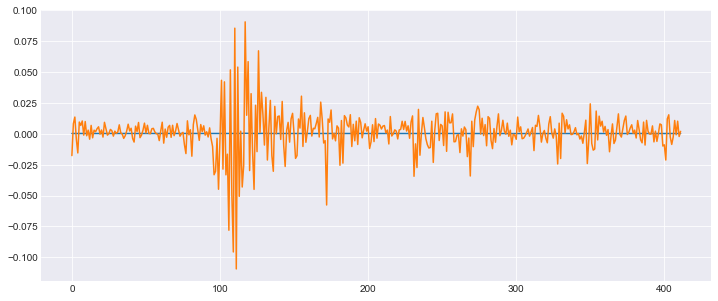

In [112]:
plt.figure(figsize=(12, 5))
plt.plot(preds)
plt.plot(y_test)